# Real or Not? NLP with Disaster Tweets - RNN

[Predict which Tweets are about real disasters and which ones are not](https://www.kaggle.com/c/nlp-getting-started)

_Y. Sun_

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

from tqdm import tqdm

In [44]:
df_train = pd.read_csv('train.csv')
df_train.tail(3)

## Deep learning model

In [ ]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    df_train['text'], df_train['target'], test_size=0.2, random_state=42) 

### Dense NN layers

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [24]:
network = Sequential()

network.add(Dense(32, kernal_regularizer=regularizers.l2(0.001), 
                  activation='relu', input_shape=(14722,)))
network.add(Dropout(0,5))
network.add(Dense(32, kernal_regularizer=regularizers.l2(0.001), 
                  activation='relu'))
network.add(Dropout(0,5))
network.add(Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(X_train, y_train,
            batch_size=128, 
            epochs=10, 
            validation_data=(X_val, y_val))

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.6381 - accuracy: 0.7197 - val_loss: 0.5678 - val_accuracy: 0.7932
Epoch 2/3
6090/6090 [==============================] - 4s 683us/sample - loss: 0.4792 - accuracy: 0.8407 - val_loss: 0.4694 - val_accuracy: 0.7945
Epoch 3/3
6090/6090 [==============================] - 4s 687us/sample - loss: 0.3616 - accuracy: 0.8727 - val_loss: 0.4347 - val_accuracy: 0.8050


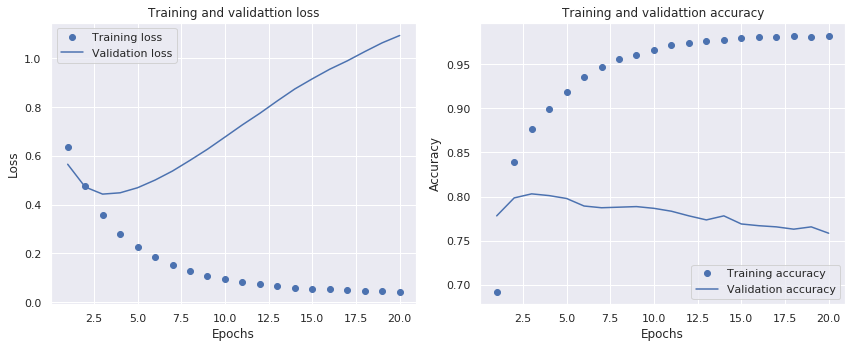

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b-', label='Validation loss')
plt.title('Training and validattion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b-', label='Validation accuracy')
plt.title('Training and validattion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
X_test = vectorizer.transform(df_test['text']).toarray()
y_pred = network.predict(X_test)

df_sub = pd.read_csv('sample_submission.csv')
df_sub['target'] = np.round(y_pred.squeeze()).astype(int)
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

### Embedding layer with GloVe

#### Word embeddings 

- Dense word vectors
- Low-dimensioanl
- Learn from data

In [ ]:
from nltk.tokenize import word_tokenize

def create_corpus(df):
    """Create corpus of the texts."""
    corpus = []
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1) & (word not in sw))]
        corpus.append(words)
    return corpus

corpus = create_corpus(df_train)

In [21]:
maxlen = 50
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences=tokenizer.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')

word_index = tokenizer.word_index
print('Number of unique words:',len(word_index))

In [20]:
embedding_dict = {}
with open('/home/ys/data/nlp-getting-started/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors

In [23]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 13077/13077 [00:00<00:00, 92236.37it/s] 


#### Embedding

In [91]:
# save dataframe data to list
texts = df_train['text'].values.tolist()
labels = df_train['target'].values.tolist()
len(texts)

7613

In [96]:
# tokenizing the text data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 30
training_samples = 6000
validation_samples = 1613
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

## shuffle the data if not random
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
print('Shape of x_train tensor:', x_train.shape)
print('Shape of x_val tensor:', x_val.shape)

Found 22700 unique tokens.
Shape of data tensor: (7613, 30)
Shape of label tensor: (7613,)
Shape of x_train tensor: (6000, 30)
Shape of x_val tensor: (1613, 30)


In [101]:
# parsing the GloVe word-embeddings file

glove_dir = '/home/ys/data/nlp-getting-started'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [126]:
# preparing the GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tqdm(word_index.items()):
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

100%|██████████| 22700/22700 [00:00<00:00, 285147.35it/s]


In [103]:
# model definition
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                96032     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,096,065
Trainable params: 1,096,065
Non-trainable params: 0
_________________________________________________________________


In [104]:
# load the pretrained word embeddings (GloVe) into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [106]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10,  
                    batch_size=32,  
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 6000 samples, validate on 1613 samples
Epoch 1/10
6000/6000 [==============================] - 5s 859us/sample - loss: 0.3492 - acc: 0.8477 - val_loss: 0.5084 - val_acc: 0.7712
Epoch 2/10
6000/6000 [==============================] - 3s 473us/sample - loss: 0.2874 - acc: 0.8797 - val_loss: 0.5368 - val_acc: 0.7644
Epoch 3/10
6000/6000 [==============================] - 3s 424us/sample - loss: 0.2413 - acc: 0.9078 - val_loss: 0.5800 - val_acc: 0.7663
Epoch 4/10
6000/6000 [==============================] - 2s 398us/sample - loss: 0.2025 - acc: 0.9240 - val_loss: 0.6411 - val_acc: 0.7539
Epoch 5/10
6000/6000 [==============================] - 3s 419us/sample - loss: 0.1736 - acc: 0.9410 - val_loss: 0.6752 - val_acc: 0.7582
Epoch 6/10
6000/6000 [==============================] - 3s 469us/sample - loss: 0.1518 - acc: 0.9495 - val_loss: 0.7436 - val_acc: 0.7495
Epoch 7/10
6000/6000 [==============================] - 4s 590us/sample - loss: 0.1299 - acc: 0.9593 - val_loss: 0.7593 - va

In [122]:
# Training the same model without pretrained word embeddings
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc']) 
history = model.fit(x_train, y_train, 
                    epochs=2, 
                    batch_size=32, 
                    validation_data=(x_val, y_val))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                96032     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,096,065
Trainable params: 1,096,065
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 1613 samples
Epoch 1/2
6000/6000 [==============================] - 7s 1ms/sample - loss: 0.5706 - acc: 0.7035 - val_loss: 0.5136 - val_acc: 0.7446
Epoch 2/2
6000/6000 [==============================] - 5s 8

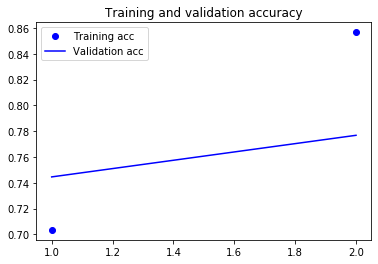

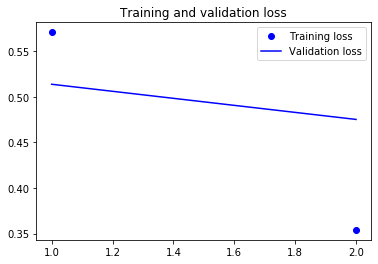

In [123]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [125]:
texts = df_test['text'].values.tolist()
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)

y_pred = model.predict(x_test)

df_sub = pd.read_csv('sample_submission.csv')
df_sub['target'] = np.round(y_pred.squeeze()).astype(int)
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [36]:
# !kaggle competitions submit -c nlp-getting-started -f submission.csv -m 'message'
# !kaggle competitions submissions -c nlp-getting-started